In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn import model_selection

import warnings
import joblib
import datetime

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from hpsklearn import HyperoptEstimator
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from hyperopt import hp
from hyperopt.plotting import main_plot_history, main_plot_histogram, main_plot_vars

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [3]:
'''Generic method to load saved object in a file to object using pickle.'''
def load_pickle_to_obj(filename):
    obj = None
    with open(filename, 'rb') as f:
        obj=pickle.load(f)
    return obj

In [4]:
X_train_after_feature_engg_file="X_train_feature_enggineered_df.pkl"
y_train_file="y_train.pkl"
X_test_after_feature_engg_file="X_test_feature_enggineered_df.pkl"
y_test_file="y_test.pkl"

X_train=load_pickle_to_obj(X_train_after_feature_engg_file)
y_train=load_pickle_to_obj(y_train_file)
X_test=load_pickle_to_obj(X_test_after_feature_engg_file)
y_test=load_pickle_to_obj(y_test_file)

In [5]:
y_train

12846     77.727083
16096      6.919444
52740     16.013194
135624     9.829861
55379     18.429167
            ...    
41993      6.874306
97639      5.104167
95939      5.010417
117952     5.036806
43567     12.340278
Name: time_taken_to_complete, Length: 99198, dtype: float64

In [6]:
y_train_24   = y_train/24
y_train_1000 = y_train/1000

y_test_24   = y_test/24
y_test_1000 = y_test/1000

In [7]:
X_train.shape, X_test.shape

((99198, 35), (42514, 35))

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99198 entries, 12846 to 43567
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   reassignment_count                 99198 non-null  object
 1   reopen_count                       99198 non-null  object
 2   sys_mod_count                      99198 non-null  object
 3   impact                             99198 non-null  object
 4   urgency                            99198 non-null  object
 5   priority                           99198 non-null  object
 6   caller_id_num                      99198 non-null  object
 7   sys_updated_by_num                 99198 non-null  object
 8   location_num                       99198 non-null  object
 9   category_num                       99198 non-null  object
 10  subcategory_num                    99198 non-null  object
 11  closed_code_num                    99198 non-null  object
 12  

In [9]:
float_data_type_features=['reassignment_count', 'reopen_count', 'sys_mod_count','sys_updated_at_ms']
int_data_type_features=['impact','urgency','priority','caller_id_num','sys_updated_by_num','location_num', 
'category_num', 'subcategory_num', 'closed_code_num', 'resolved_by_num', 'incident_state_Awaiting Evidence',
'incident_state_Awaiting Problem','incident_state_Awaiting User Info',
'incident_state_Awaiting Vendor', 'incident_state_Closed','incident_state_New',
'incident_state_Resolved','active_True','made_sla_True', 'contact_type_Email','contact_type_IVR',
'contact_type_Phone', 'contact_type_Self service','knowledge_True','u_priority_confirmation_True',
'notify_Send Email','sys_created_by_num','u_symptom_num','opened_by_num', 'assignment_group_num','assigned_to_num']

In [10]:
# https://www.geeksforgeeks.org/python-pandas-dataframe-astype/
for col in float_data_type_features:
    X_train[col]=X_train[col].astype("float64")
    X_test[col]=X_test[col].astype("float64")
    
for col in int_data_type_features:
    X_train[col]=X_train[col].astype("int64")
    X_test[col]=X_test[col].astype("int64")

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99198 entries, 12846 to 43567
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   reassignment_count                 99198 non-null  float64
 1   reopen_count                       99198 non-null  float64
 2   sys_mod_count                      99198 non-null  float64
 3   impact                             99198 non-null  int64  
 4   urgency                            99198 non-null  int64  
 5   priority                           99198 non-null  int64  
 6   caller_id_num                      99198 non-null  int64  
 7   sys_updated_by_num                 99198 non-null  int64  
 8   location_num                       99198 non-null  int64  
 9   category_num                       99198 non-null  int64  
 10  subcategory_num                    99198 non-null  int64  
 11  closed_code_num                    99198 non-null 

<h3>ML Models</h3>

In [12]:
state=7
models_and_mse ={}
models_24_and_mse ={}
models_1000_and_mse ={}

In [13]:
# prepare ml_models
ml_models = []
ml_models_24 = []
ml_models_1000 = []

ml_models.append(('LR', LinearRegression()))
ml_models.append(('Ridge', Ridge(random_state=state)))
ml_models.append(('Lasso', Lasso(random_state=state)))
ml_models.append(('ElasticNet', ElasticNet(random_state=state)))
ml_models.append(('KNN Regressor', KNeighborsRegressor()))


ml_models_24.append(('LR', LinearRegression()))
ml_models_24.append(('Ridge', Ridge(random_state=state)))
ml_models_24.append(('Lasso', Lasso(random_state=state)))
ml_models_24.append(('ElasticNet', ElasticNet(random_state=state)))
ml_models_24.append(('KNN Regressor', KNeighborsRegressor()))

ml_models_1000.append(('LR', LinearRegression()))
ml_models_1000.append(('Ridge', Ridge(random_state=state)))
ml_models_1000.append(('Lasso', Lasso(random_state=state)))
ml_models_1000.append(('ElasticNet', ElasticNet(random_state=state)))
ml_models_1000.append(('KNN Regressor', KNeighborsRegressor()))

In [14]:
list_y_type=["og","by_1000","by_24"]

In [15]:
def train_models(ml_models_dict,y_train, y_test, models_and_mse):
    for name, model in ml_models_dict:
        a = datetime.datetime.now()
        model.fit(X_train, y_train)
        b = datetime.datetime.now()
        #     https://stackoverflow.com/a/36878078/1225413
        print("Total time taken to fit {0:<15} - {1}".format(name,str(b-a)))
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        models_and_mse[name] = mse
    print("-"*30)

In [16]:
%%time
for i in list_y_type:
    if(i=="og"):
        train_models(ml_models, y_train, y_test, models_and_mse)
    elif(i=="by_1000"):
        train_models(ml_models_1000, y_train_1000, y_test_1000, models_1000_and_mse)
    else:
        train_models(ml_models_24, y_train_24, y_test_24, models_24_and_mse)

Total time taken to fit LR              - 0:00:00.098283
Total time taken to fit Ridge           - 0:00:00.047039
Total time taken to fit Lasso           - 0:00:00.315921
Total time taken to fit ElasticNet      - 0:00:00.352277
Total time taken to fit KNN Regressor   - 0:00:01.001606
------------------------------
Total time taken to fit LR              - 0:00:00.071059
Total time taken to fit Ridge           - 0:00:00.042037
Total time taken to fit Lasso           - 0:00:00.049713
Total time taken to fit ElasticNet      - 0:00:00.050032
Total time taken to fit KNN Regressor   - 0:00:00.972338
------------------------------
Total time taken to fit LR              - 0:00:00.073061
Total time taken to fit Ridge           - 0:00:00.041038
Total time taken to fit Lasso           - 0:00:00.075065
Total time taken to fit ElasticNet      - 0:00:00.084080
Total time taken to fit KNN Regressor   - 0:00:00.941062
------------------------------
Wall time: 27.4 s


In [17]:
models_and_mse, models_1000_and_mse, models_24_and_mse

({'LR': 525.0969585648465,
  'Ridge': 525.0962501398766,
  'Lasso': 456.2021582761336,
  'ElasticNet': 524.5266045878856,
  'KNN Regressor': 821.8421122725698},
 {'LR': 0.0005250969585648412,
  'Ridge': 0.0005250962501398761,
  'Lasso': 0.0007086960435648666,
  'ElasticNet': 0.0007086960435648666,
  'KNN Regressor': 0.0008218421122725698},
 {'LR': 0.9116266641750419,
  'Ridge': 0.9116254342706185,
  'Lasso': 1.240302369534868,
  'ElasticNet': 1.1296566096200134,
  'KNN Regressor': 1.4268092226954339})

In [18]:
dt_bagging_boosting_models = []
dt_bagging_boosting_models_1000 = []
dt_bagging_boosting_models_24 = []

dt_bagging_boosting_models.append(('DecisionTreeRegressor', DecisionTreeRegressor(criterion='mse',random_state=state)))
dt_bagging_boosting_models.append(('tree.ExtraTreeRegressor', ExtraTreeRegressor(criterion='mse',random_state=state)))
dt_bagging_boosting_models.append(('ensemble.ExtraTreesRegressor', ExtraTreesRegressor(criterion='mse',random_state=state)))
dt_bagging_boosting_models.append(('BaggingRegressor', BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse'),random_state=state) ))
dt_bagging_boosting_models.append(('RandomForestRegressor', RandomForestRegressor(criterion='mse',random_state=state)))
dt_bagging_boosting_models.append(('XGBoostRegressor', XGBRegressor(random_state=state,objective='reg:squarederror')))
dt_bagging_boosting_models.append(('LGBMRegressor', LGBMRegressor(random_state=state, objective='regression', metric='mse')))


dt_bagging_boosting_models_1000.append(('DecisionTreeRegressor', DecisionTreeRegressor(criterion='mse',random_state=state)))
dt_bagging_boosting_models_1000.append(('tree.ExtraTreeRegressor', ExtraTreeRegressor(criterion='mse',random_state=state)))
dt_bagging_boosting_models_1000.append(('ensemble.ExtraTreesRegressor', ExtraTreesRegressor(criterion='mse',random_state=state)))
dt_bagging_boosting_models_1000.append(('BaggingRegressor', BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse'),random_state=state) ))
dt_bagging_boosting_models_1000.append(('RandomForestRegressor', RandomForestRegressor(criterion='mse',random_state=state)))
dt_bagging_boosting_models_1000.append(('XGBoostRegressor', XGBRegressor(random_state=state,objective='reg:squarederror')))
dt_bagging_boosting_models_1000.append(('LGBMRegressor', LGBMRegressor(random_state=state, objective='regression', metric='mse')))


dt_bagging_boosting_models_24.append(('DecisionTreeRegressor', DecisionTreeRegressor(criterion='mse',random_state=state)))
dt_bagging_boosting_models_24.append(('tree.ExtraTreeRegressor', ExtraTreeRegressor(criterion='mse',random_state=state)))
dt_bagging_boosting_models_24.append(('ensemble.ExtraTreesRegressor', ExtraTreesRegressor(criterion='mse',random_state=state)))
dt_bagging_boosting_models_24.append(('BaggingRegressor', BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse'),random_state=state) ))
dt_bagging_boosting_models_24.append(('RandomForestRegressor', RandomForestRegressor(criterion='mse',random_state=state)))
dt_bagging_boosting_models_24.append(('XGBoostRegressor', XGBRegressor(random_state=state,objective='reg:squarederror')))
dt_bagging_boosting_models_24.append(('LGBMRegressor', LGBMRegressor(random_state=state, objective='regression', metric='mse')))

In [19]:
%%time
for i in list_y_type:
    if(i=="og"):
        train_models(dt_bagging_boosting_models, y_train, y_test, models_and_mse)
    elif(i=="by_1000"):
        train_models(dt_bagging_boosting_models_1000, y_train_1000, y_test_1000, models_1000_and_mse)
    else:
        train_models(dt_bagging_boosting_models_24, y_train_24, y_test_24, models_24_and_mse)

Total time taken to fit DecisionTreeRegressor - 0:00:01.193021
Total time taken to fit tree.ExtraTreeRegressor - 0:00:00.388337
Total time taken to fit ensemble.ExtraTreesRegressor - 0:00:36.354012
Total time taken to fit BaggingRegressor - 0:00:07.727989
Total time taken to fit RandomForestRegressor - 0:01:15.889330
Total time taken to fit XGBoostRegressor - 0:00:02.959580
Total time taken to fit LGBMRegressor   - 0:00:00.384485
------------------------------
Total time taken to fit DecisionTreeRegressor - 0:00:01.104632
Total time taken to fit tree.ExtraTreeRegressor - 0:00:00.338294
Total time taken to fit ensemble.ExtraTreesRegressor - 0:00:32.468829
Total time taken to fit BaggingRegressor - 0:00:07.202466
Total time taken to fit RandomForestRegressor - 0:01:09.528133
Total time taken to fit XGBoostRegressor - 0:00:02.892990
Total time taken to fit LGBMRegressor   - 0:00:00.426437
------------------------------
Total time taken to fit DecisionTreeRegressor - 0:00:01.199283
Total t

In [20]:
models_and_mse, models_1000_and_mse, models_24_and_mse

({'LR': 525.0969585648465,
  'Ridge': 525.0962501398766,
  'Lasso': 456.2021582761336,
  'ElasticNet': 524.5266045878856,
  'KNN Regressor': 821.8421122725698,
  'DecisionTreeRegressor': 5122.962176091359,
  'tree.ExtraTreeRegressor': 2413.2294097537683,
  'ensemble.ExtraTreesRegressor': 490.52980752552014,
  'BaggingRegressor': 763.0945535814857,
  'RandomForestRegressor': 1011.7157132359835,
  'XGBoostRegressor': 1532.5172838561398,
  'LGBMRegressor': 499.33676542247224},
 {'LR': 0.0005250969585648412,
  'Ridge': 0.0005250962501398761,
  'Lasso': 0.0007086960435648666,
  'ElasticNet': 0.0007086960435648666,
  'KNN Regressor': 0.0008218421122725698,
  'DecisionTreeRegressor': 0.005048729638477671,
  'tree.ExtraTreeRegressor': 0.00112180398683629,
  'ensemble.ExtraTreesRegressor': 0.0005109095553354734,
  'BaggingRegressor': 0.0007782775493312484,
  'RandomForestRegressor': 0.000971537579869007,
  'XGBoostRegressor': 0.001756765056287205,
  'LGBMRegressor': 0.0004993367664530283},
 {'L

In [21]:
ds = [models_and_mse, models_1000_and_mse, models_24_and_mse]
d = {}
for k in models_and_mse:
    d[k] = tuple(d[k] for d in ds)

In [22]:
# https://stackoverflow.com/a/42869605/1225413
df=pd.concat({k: pd.Series(v) for k, v in d.items()}, axis=1)
df=df.T

In [50]:
df

,Regression Models,mse_score_with_y_train,mse_score_with_y_train_1000,mse_score_with_y_train_24
0,LR,525.096959,0.000525,0.911627
1,Ridge,525.096250,0.000525,0.911625
2,Lasso,456.202158,0.000709,1.240302
3,ElasticNet,524.526605,0.000709,1.129657
4,KNN Regressor,821.842112,0.000822,1.426809
5,DecisionTreeRegressor,5122.962176,0.005049,2.823465
6,tree.ExtraTreeRegressor,2413.229410,0.001122,1.251246
7,ensemble.ExtraTreesRegressor,490.529808,0.000511,0.892294
8,BaggingRegressor,763.094554,0.000778,1.804704
9,RandomForestRegressor,1011.715713,0.000972,1.572943


In [23]:
# https://stackoverflow.com/a/11346337/1225413
df.columns = ['mse_score_with_y_train', 'mse_score_with_y_train_1000', 'mse_score_with_y_train_24']

In [24]:
df[df==df["mse_score_with_y_train"].min()]

,mse_score_with_y_train,mse_score_with_y_train_1000,mse_score_with_y_train_24
LR,NaN,NaN,NaN
Ridge,NaN,NaN,NaN
Lasso,456.202158,NaN,NaN
ElasticNet,NaN,NaN,NaN
KNN Regressor,NaN,NaN,NaN
DecisionTreeRegressor,NaN,NaN,NaN
tree.ExtraTreeRegressor,NaN,NaN,NaN
ensemble.ExtraTreesRegressor,NaN,NaN,NaN
BaggingRegressor,NaN,NaN,NaN
RandomForestRegressor,NaN,NaN,NaN


{k: v for k, v in sorted(models_and_mse.items(), key=lambda item: item[1])}

In [25]:
df[df==df["mse_score_with_y_train_1000"].min()]

,mse_score_with_y_train,mse_score_with_y_train_1000,mse_score_with_y_train_24
LR,NaN,NaN,NaN
Ridge,NaN,NaN,NaN
Lasso,NaN,NaN,NaN
ElasticNet,NaN,NaN,NaN
KNN Regressor,NaN,NaN,NaN
DecisionTreeRegressor,NaN,NaN,NaN
tree.ExtraTreeRegressor,NaN,NaN,NaN
ensemble.ExtraTreesRegressor,NaN,NaN,NaN
BaggingRegressor,NaN,NaN,NaN
RandomForestRegressor,NaN,NaN,NaN


In [26]:
df[df==df["mse_score_with_y_train_24"].min()]

,mse_score_with_y_train,mse_score_with_y_train_1000,mse_score_with_y_train_24
LR,NaN,NaN,NaN
Ridge,NaN,NaN,NaN
Lasso,NaN,NaN,NaN
ElasticNet,NaN,NaN,NaN
KNN Regressor,NaN,NaN,NaN
DecisionTreeRegressor,NaN,NaN,NaN
tree.ExtraTreeRegressor,NaN,NaN,NaN
ensemble.ExtraTreesRegressor,NaN,NaN,NaN
BaggingRegressor,NaN,NaN,NaN
RandomForestRegressor,NaN,NaN,NaN


In [27]:
# https://www.geeksforgeeks.org/how-to-convert-index-to-column-in-pandas-dataframe/
df=df.reset_index(level=0, inplace=False)

In [28]:
# https://stackoverflow.com/a/11346337/1225413
columns=df.columns
columns.values[0]="Regression Models"
df.columns=columns

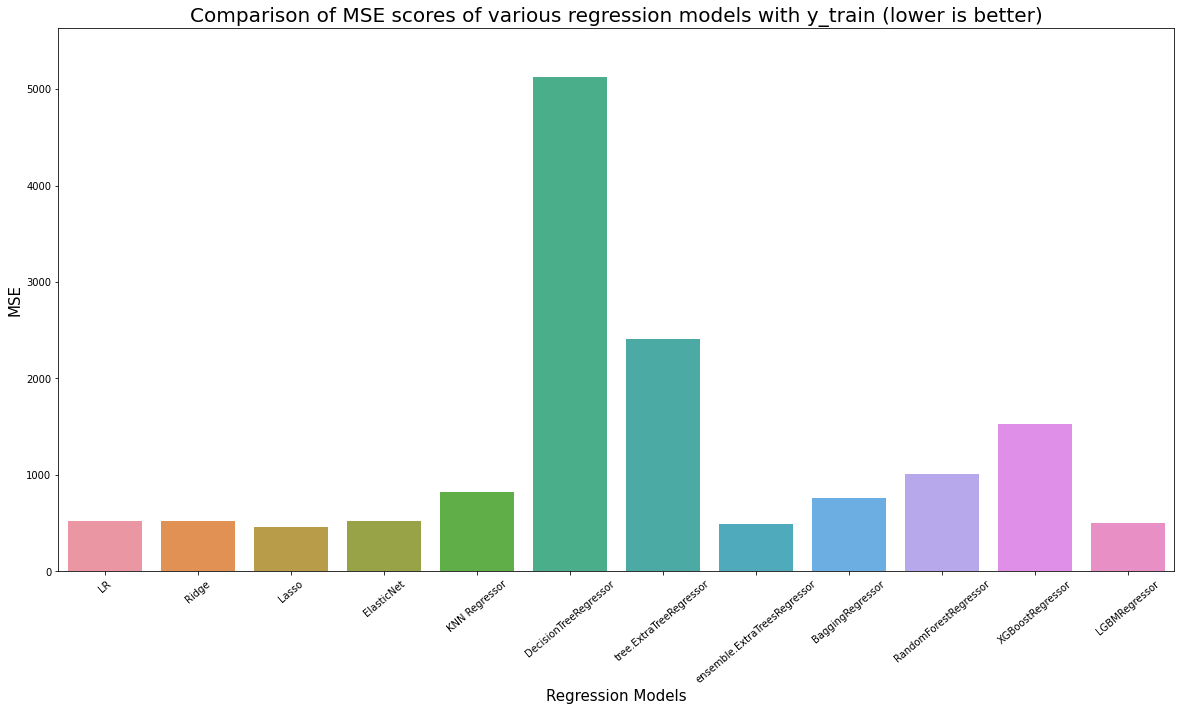

In [34]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)

# https://stackoverflow.com/a/36222162/1225413
b=sns.barplot(x="Regression Models",y="mse_score_with_y_train",data=df)
plt.xticks(rotation=40)
b.axes.set_title("Comparison of MSE scores of various regression models with y_train (lower is better)",fontsize=20)
b.set_xlabel("Regression Models",fontsize=15)
b.set_ylabel("MSE",fontsize=15)
plt.ylim(0, df["mse_score_with_y_train"].max()+(df["mse_score_with_y_train"].max()*0.1))
plt.show()

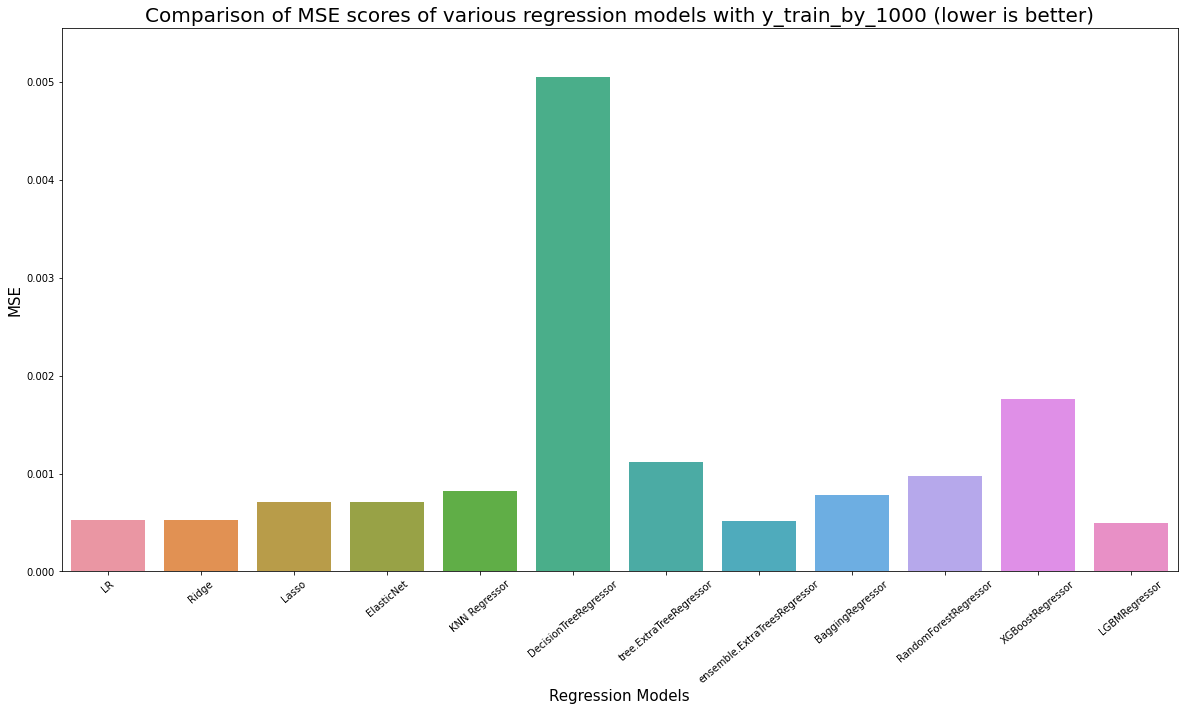

In [35]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)

# https://stackoverflow.com/a/36222162/1225413
b=sns.barplot(x="Regression Models",y="mse_score_with_y_train_1000",data=df)
plt.xticks(rotation=40)
b.axes.set_title("Comparison of MSE scores of various regression models with y_train_by_1000 (lower is better)",fontsize=20)
b.set_xlabel("Regression Models",fontsize=15)
b.set_ylabel("MSE",fontsize=15)
plt.ylim(0, df["mse_score_with_y_train_1000"].max()+(df["mse_score_with_y_train_1000"].max()*0.1))
plt.show()

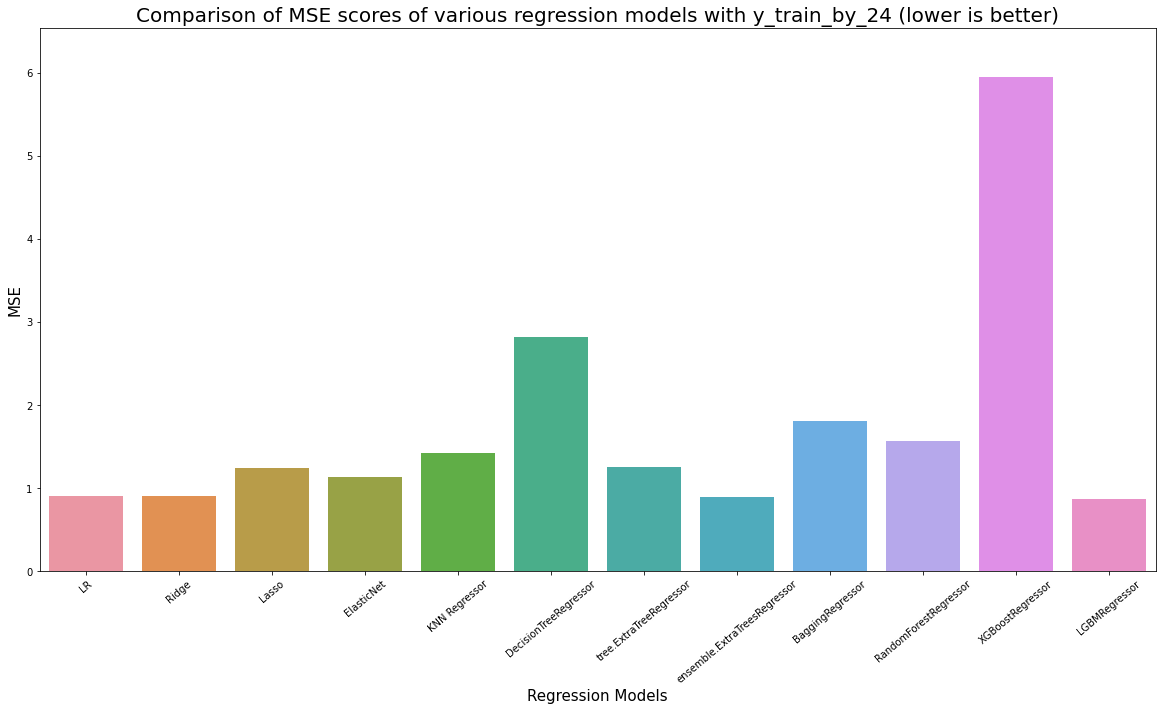

In [36]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)

# https://stackoverflow.com/a/36222162/1225413
b=sns.barplot(x="Regression Models",y="mse_score_with_y_train_24",data=df)
plt.xticks(rotation=40)
b.axes.set_title("Comparison of MSE scores of various regression models with y_train_by_24 (lower is better)",fontsize=20)
b.set_xlabel("Regression Models",fontsize=15)
b.set_ylabel("MSE",fontsize=15)
plt.ylim(0, df["mse_score_with_y_train_24"].max()+(df["mse_score_with_y_train_24"].max()*0.1))
plt.show()

<h3>Observation:</h3>

LightGBM gives least MSE for the data. We need to further hyper-paramter tune it.

In [37]:
# https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e
class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)            
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def lgb_reg(self, para):
        reg = LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK, 'para':para}

In [38]:
colsample_bytree_list = np.arange(0.3, 0.8, 0.1)
lambda_l1_list        = [0.0, 0.1, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0]
max_depth_list        = np.arange(5, 16, 1, dtype=int)
max_bin_list          = np.arange(15, 255, 15)
num_iterations_list   = np.arange(50, 1000, 50)
learning_rate_list    = np.arange(0.05, 0.31, 0.05)
min_child_weight_list = np.arange(1, 8, 1, dtype=int)
num_leaves_list       = [25, 30, 50, 100, 200, 300, 500]

In [39]:
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate', learning_rate_list),
    'max_depth':        hp.choice('max_depth', max_depth_list),
    'min_child_weight': hp.choice('min_child_weight', min_child_weight_list),
    'colsample_bytree': hp.choice('colsample_bytree', colsample_bytree_list),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'lambda_l1':        hp.choice('lambda_l1',   lambda_l1_list),
    'num_leaves' :      hp.choice('num_leaves', num_leaves_list),
    'max_bin':          hp.choice('max_bin', max_bin_list),
    'num_iterations':   hp.choice('num_iterations', num_iterations_list),
    'n_estimators':     100,
    'boosting_type':    'gbdt'
}
lgb_fit_params = {
    'verbose': 0
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: (mean_squared_error(y, pred))

<h3>Obesrvation:</h3>
Since dividing by 1000 gave the lost MSE score, we will use the same to Hyper-parameter tune LGBRegressor. 

In [40]:
%%time
obj = HPOpt(X_train, X_test, y_train_1000, y_test_1000)
trials=Trials()
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=trials, algo=tpe.suggest, max_evals=500)

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5                 
[LightGBM] [Warning] lambda_l1 is set=2.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0                 
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5                 
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0                 
[LightGBM] [Warning] lambda_l1 is set=3.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0                 
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0                 
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0                 
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0                 
[LightGBM] [Warning] lambda_l1 is set=0.

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5                 
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0                 
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0                 
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0               
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5                 
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0                 
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0                 
[LightGBM] [Warning] lambda_l1 is set=2.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0                 
[LightGBM] [Warning] lambda_l1 is set=3.

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1                 
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0                 
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1                 
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1                 
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0                 
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1                 
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0               
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1                 
[LightGBM] [Warning] lambda_l1 is set=2.

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1                 
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1                 
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1                 
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1                 
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1                 
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1                 
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1                 
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1                 
[LightGBM] [Warning] lambda_l1 is set=0.

avg best error: 0.0004442605577596711


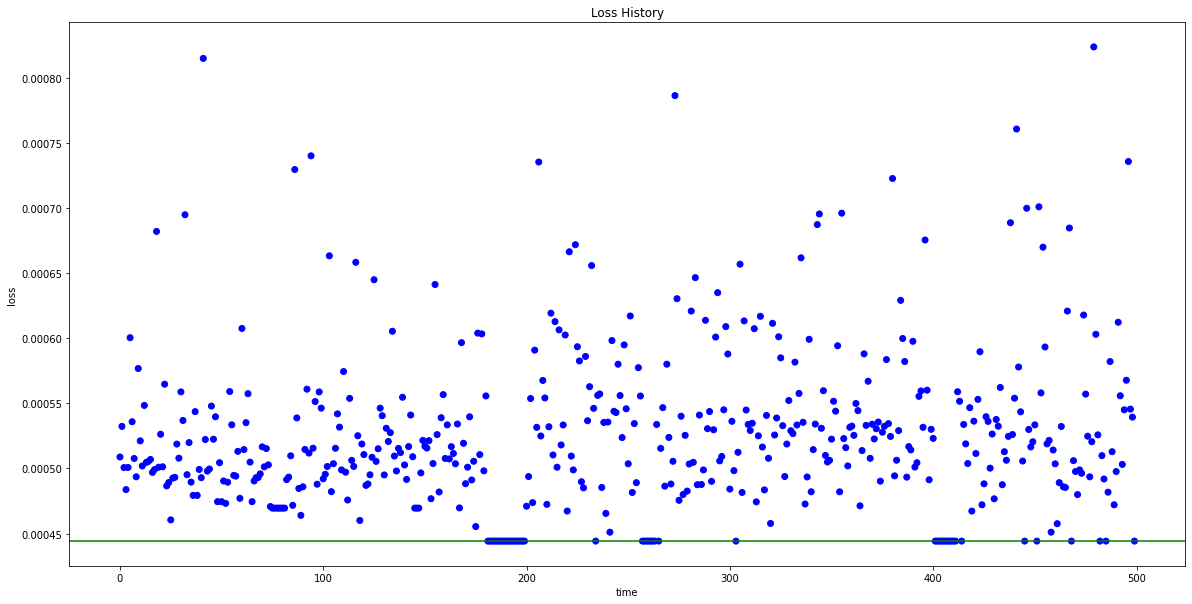

In [41]:
# https://towardsdatascience.com/hyperparameter-optimization-in-python-part-2-hyperopt-5f661db91324
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
main_plot_history(trials)

<h3>Observation:</h3>

The green line represent for best/least error loss, we can see lot of points which are in the same range which validate that we are searching in right space to optimize our model.

Showing Histogram of 500 jobs


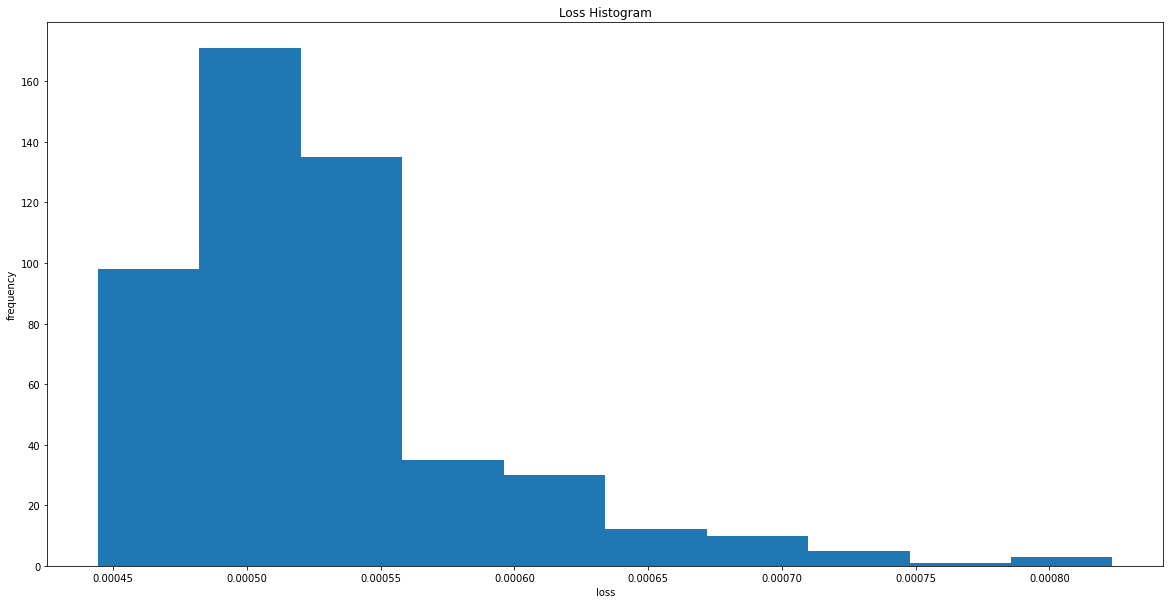

In [42]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
main_plot_histogram(trials)

<h3>Observation:</h3>

From the plot it is quite evident that most of the mse score/loss values for LGBMRegressor lie in the range of <=35K.

finite loss range 0.0004442605577596711 0.000823599876698311 -0.9995557394422403


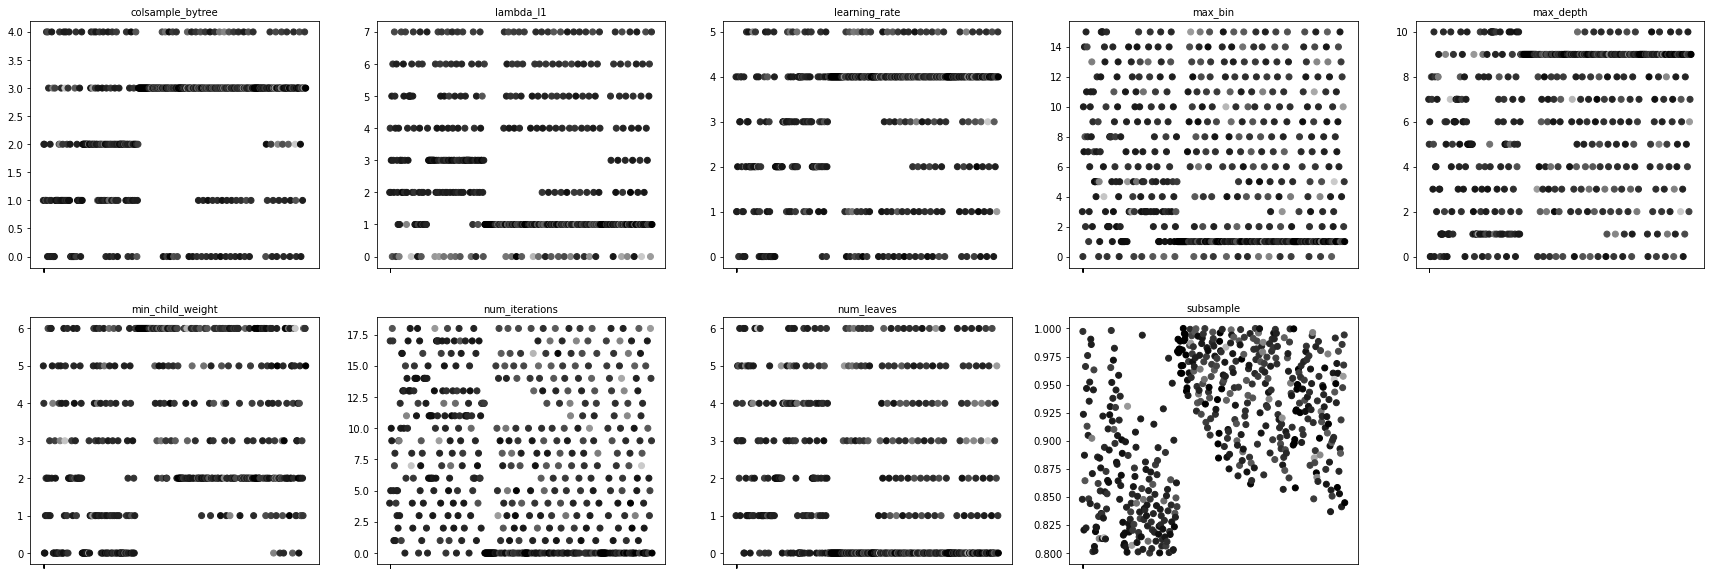

In [43]:
fig_dims = (30, 10)
fig, ax = plt.subplots(figsize=fig_dims)
main_plot_vars(trials)

<h3>Observation:</h3>

The above plot show variance of hyper-parameter values for LGBMRegressor.

In [44]:
lgb_opt[0]

{'colsample_bytree': 3,
 'lambda_l1': 1,
 'learning_rate': 4,
 'max_bin': 1,
 'max_depth': 9,
 'min_child_weight': 6,
 'num_iterations': 0,
 'num_leaves': 0,
 'subsample': 0.9795517246204657}

In [45]:
best_parameters = {'colsample_bytree':colsample_bytree_list[lgb_opt[0]['colsample_bytree']],
              'lambda_l1' :lambda_l1_list[lgb_opt[0]['lambda_l1']],
              'max_depth':max_depth_list[lgb_opt[0]['max_depth']],
              'max_bin': max_bin_list[lgb_opt[0]['max_bin']],
              'num_iterations':num_iterations_list[lgb_opt[0]['num_iterations']],
              'learning_rate': learning_rate_list[lgb_opt[0]['learning_rate']],
              'min_child_weight': min_child_weight_list[lgb_opt[0]['min_child_weight']],
              'num_leaves': num_leaves_list[lgb_opt[0]['num_leaves']],
              'subsample': lgb_opt[0]['subsample'],
              'n_estimators':  100
             }

In [46]:
best_lgbm_reg=LGBMRegressor(random_state=state, objective='regression', metric='mse', verbose=0)
best_lgbm_reg.set_params(**best_parameters)

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.6000000000000001, importance_type='split',
              lambda_l1=0.1, learning_rate=0.25, max_bin=30, max_depth=14,
              metric='mse', min_child_samples=20, min_child_weight=7,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1,
              num_iterations=50, num_leaves=25, objective='regression',
              random_state=7, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.9795517246204657, subsample_for_bin=200000,
              subsample_freq=0, verbose=0)

In [47]:
a = datetime.datetime.now()
best_lgbm_reg.fit(X_train, y_train)
b = datetime.datetime.now()
#     https://stackoverflow.com/a/36878078/1225413
print("Total time taken to fit {0:<30} - {1}".format("LGBRegressor",str(b-a)))
best_y_pred = best_lgbm_reg.predict(X_test)
best_mse = mean_squared_error(y_test, best_y_pred)
best_mse

print("MSE",best_mse, " | RMSE",np.sqrt(best_mse))

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Total time taken to fit LGBRegressor                   - 0:00:00.210609
MSE 510.0348179344104  | RMSE 22.5839504501407


In [48]:
filename = 'hyper_opt_lgbm_reg.sav'
joblib.dump(obj, filename, compress=3)

['hyper_opt_lgbm_reg.sav']

In [49]:
filename = 'lgbm_reg_model.sav'
joblib.dump(best_lgbm_reg, filename, compress=3)

['lgbm_reg_model.sav']

<h3>Observation:</h3>
The best MSE score is based on dividing values by 1000 of y_train and its RMSE is 505.